In [1]:
!pip install opencv-python

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## View images

Width: 736 pixels
Height: 736 pixels
Number of channels: 3
Image size: 1625088 bytes
Image data type: uint8


(-0.5, 735.5, 735.5, -0.5)

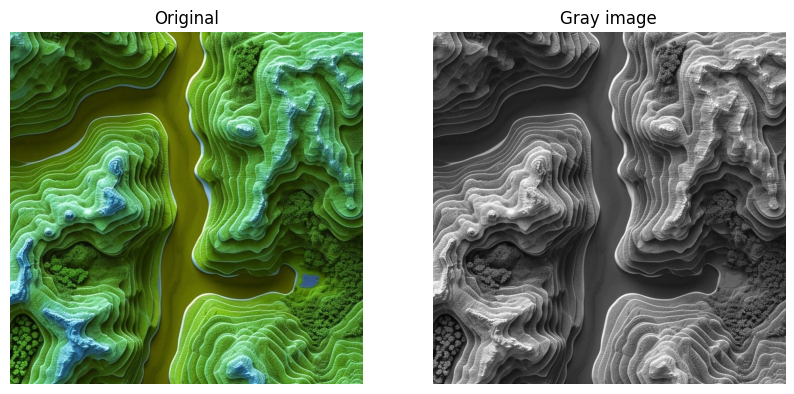

In [3]:
img = cv2.imread('images/hills.jpeg')
# plt.imshow(img)

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_image, cmap='gray')

height, width, channels = img.shape
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")
print(f"Number of channels: {channels}")
print(f"Image size: {img.size} bytes")
print(f"Image data type: {img.dtype}")

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray image')
plt.axis('off')


## Uniform gray image quantization
level = 20

True

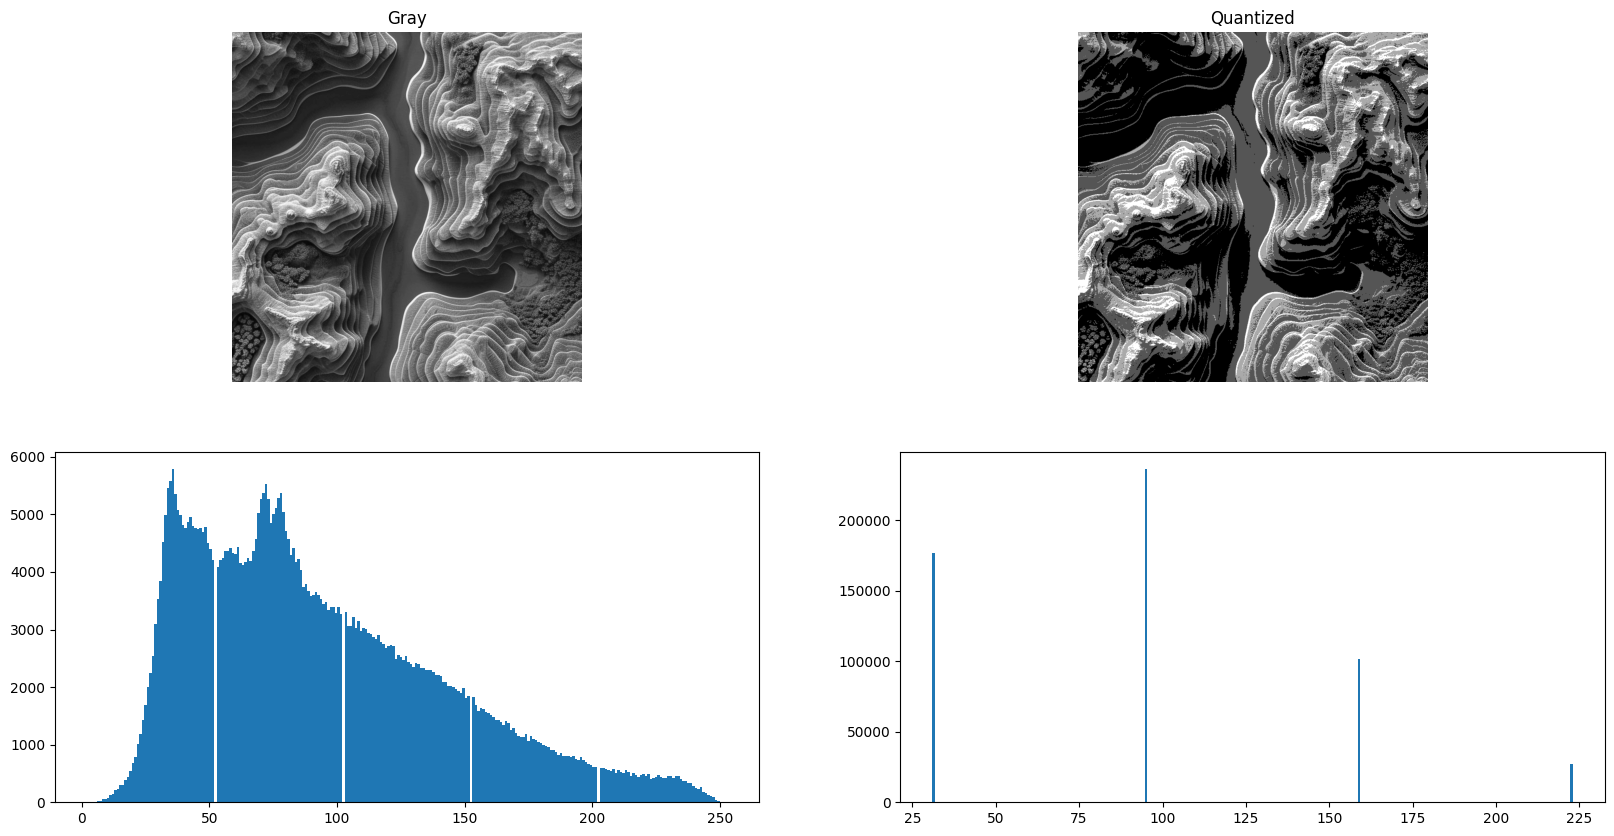

In [24]:
level = 4

quantized_image = np.array(gray_image).copy()
delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        quantized_image[i][j] = int(np.floor(gray_image[i][j]/delta)*delta+delta/2)

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title('Quantized')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite('images/gray_hills.jpeg',gray_image)
cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

## Median cut

https://web.archive.org/web/20190202154003/http://www.leptonica.com/papers/mediancut.pdf